Recordar consultar el [Diccionario de datos](./Datasets/Google%20Maps/Diccionario%20de%20datos.docx)


# Importaciones

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ast
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
import geojson

# Llamado de datos a dataframes

In [96]:
df_restaurantes = pd.read_parquet(r'Datawarehouse\restaurantes.parquet')
df_reviews = pd.read_parquet(r'Datawarehouse\reviews.parquet')
df_estados = pd.read_parquet(r'Datawarehouse\estados.parquet')

# Google Maps Cadenas

Comenzaremos limpiando los dataframes de Reviews y Restaurantes de Google Maps


In [97]:
df_restaurantes.isnull().sum()

id_restaurante        0
id_estado             0
nombre                0
categorias            0
cantidad_resenas      0
latitud               0
longitud              0
atributos           868
calificacion          0
dtype: int64

crearemos dos funciones que serviran para  arreglar los errores de computo dentro de los estados, estos codigos utilian las coordenadas y unos diccionarios con la informacion para computar el valor correcto

In [98]:
state_dictionary = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}

with open("Geojson/us-states.json", "r") as f: 
    data_geo_1 = geojson.load(f)
with open("Geojson/geojson-counties-fips.json", "r") as f:
    data_geo_2 = geojson.load(f)


def get_state(lat, lon):
    def search_states(data_geo, state_dict):
        for feature in data_geo["features"]:
            try:
                geometry_type = feature["geometry"]["type"]
                if geometry_type == "Polygon":
                    coordinates = feature["geometry"]["coordinates"][0]
                elif geometry_type == "MultiPolygon":
                    coordinates = [
                        sub_coords[0]
                        for sub_coords in feature["geometry"]["coordinates"]]
                else: continue
                polygon = Polygon(coordinates)
                if polygon.contains(Point(lon, lat)):
                    state_abbr = feature["properties"]["STATE"]
                    return state_dict[state_abbr]
            except (KeyError, IndexError): pass
        return None

    state = search_states(data_geo_1, state_dictionary_inv)
    if state: return state
    state = search_states(data_geo_2, state_index_inv)
    return state


def get_state_ab(address):
    try:
        state = address.split(", ")[-1].split(" ")[0]
        if state in list(state_dictionary.keys()): return state
        else: return np.nan
    except: return np.nan


state_index = pd.read_parquet("Datalake/estados.parquet")["State"].to_dict()
state_index_inv = {v: k for k, v in state_index.items()}
state_dictionary_inv = {v: k for k, v in state_dictionary.items()}

Completaremos los valores faltantes en MISC de subway, burguer king, Dunkin y Mc Donald´s con los valores de un MISC completo de sus respesctivos

Para eso primero obtenemos el valor, lo acomodamos para darle su formato diccionario y lo agregamos en donde haya nulos

In [99]:
subway_df = df_restaurantes[df_restaurantes['nombre'].str.contains('subway')]
if not subway_df.empty:
    print(subway_df['atributos'].iloc[0])

{'AcceptsInsurance': None, 'Accessibility': array(['Wheelchair accessible entrance'], dtype=object), 'AgesAllowed': None, 'Alcohol': None, 'Ambience': None, 'Amenities': array(['Good for kids'], dtype=object), 'Atmosphere': array(['Casual'], dtype=object), 'BYOB': None, 'BYOBCorkage': None, 'BestNights': None, 'BikeParking': None, 'BusinessAcceptsBitcoin': None, 'BusinessAcceptsCreditCards': None, 'BusinessParking': None, 'ByAppointmentOnly': None, 'Caters': None, 'CoatCheck': None, 'Corkage': None, 'Crowd': None, 'DietaryRestrictions': None, 'Dining options': array(['Lunch'], dtype=object), 'DogsAllowed': None, 'DriveThru': None, 'From the business': None, 'GoodForDancing': None, 'GoodForKids': None, 'GoodForMeal': None, 'HappyHour': None, 'HasTV': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': array(['Fast service'], dtype=object), 'Music': None, 'NoiseLevel': None, 'Offerings': array(['Healthy options', 'Quick bite'], dtype=object), 'Open24Hours': None, 'Out

In [100]:
df_restaurantes.head(1)

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion
3,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.0


In [101]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual'], 'Crowd': None, 'Dining options': 'Lunch', 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': 'Fast service', 'Offerings':['Healthy options', 'Quick bite'], 'Payments':['Debit cards', 'NFC mobile payments'], 'Planning': None, 'Popular for': ['Lunch', 'Dinner', 'Solo dining'], 'Recycling': None, 'Service options': ['Delivery', 'Takeout', 'Dine-in']}
df_restaurantes.loc[df_restaurantes['nombre'].str.lower().str.contains('subway') & df_restaurantes['atributos'].isnull(), 'atributos'] = str(diccionario_MISC)


In [102]:
dunkin_df = df_restaurantes[df_restaurantes['nombre'].str.contains('dunkin', case=False)]
if not dunkin_df.empty:
    print(dunkin_df['atributos'].iloc[0])

{'AcceptsInsurance': None, 'Accessibility': None, 'AgesAllowed': None, 'Alcohol': None, 'Ambience': None, 'Amenities': None, 'Atmosphere': None, 'BYOB': None, 'BYOBCorkage': None, 'BestNights': None, 'BikeParking': 'False', 'BusinessAcceptsBitcoin': None, 'BusinessAcceptsCreditCards': 'True', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}", 'ByAppointmentOnly': None, 'Caters': None, 'CoatCheck': None, 'Corkage': None, 'Crowd': None, 'DietaryRestrictions': None, 'Dining options': None, 'DogsAllowed': None, 'DriveThru': 'None', 'From the business': None, 'GoodForDancing': None, 'GoodForKids': None, 'GoodForMeal': None, 'HappyHour': None, 'HasTV': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': None, 'Music': None, 'NoiseLevel': None, 'Offerings': None, 'Open24Hours': None, 'OutdoorSeating': 'False', 'Payments': None, 'Planning': None, 'Popular for': None, 'Recycling': None, 'RestaurantsAttire': None, 'Resta

In [103]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance'], 'Amenities': ['Good for kids', 'Wi-Fi'],'Atmosphere': 'Casual', 'Crowd':['Family-friendly', 'Tourists'], 'Dining options':['Breakfast', 'Lunch', 'Dessert'], 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights':['Fast service', 'Great coffee'], 'Offerings': ['Coffee', 'Comfort food', 'Happy hour drinks', 'Late-night food','Quick bite'], 'Payments': ['Debit cards', 'NFC mobile payments'], 'Planning': None, 'Popular for':['Breakfast', 'Solo dining'], 'Recycling': None, 'Service options': ['Delivery', 'Takeout', 'Dine-in']}
df_restaurantes.loc[df_restaurantes['nombre'].str.lower().str.contains('dunkin') & df_restaurantes['atributos'].isnull(), 'atributos'] = str(diccionario_MISC)

In [104]:
mc_df = df_restaurantes[df_restaurantes['nombre'].str.contains('donald', case=False)]
if not mc_df.empty:
    print(mc_df['atributos'].iloc[0])

{'AcceptsInsurance': None, 'Accessibility': None, 'AgesAllowed': None, 'Alcohol': "u'none'", 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}", 'Amenities': None, 'Atmosphere': None, 'BYOB': None, 'BYOBCorkage': None, 'BestNights': None, 'BikeParking': 'True', 'BusinessAcceptsBitcoin': None, 'BusinessAcceptsCreditCards': 'True', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", 'ByAppointmentOnly': None, 'Caters': 'False', 'CoatCheck': None, 'Corkage': None, 'Crowd': None, 'DietaryRestrictions': None, 'Dining options': None, 'DogsAllowed': None, 'DriveThru': 'True', 'From the business': None, 'GoodForDancing': None, 'GoodForKids': 'True', 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': True}", 'HappyHour': None, 'HasTV': 'True', 'Health & 

In [105]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance',
       'Wheelchair accessible parking lot',
       'Wheelchair accessible restroom', 'Wheelchair accessible seating'],
       'Amenities':['Gender-neutral restroom', 'Good for kids', 'High chairs',
       'Restroom'], 'Atmosphere': None, 'Crowd': None, 'Dining options': ['Breakfast', 'Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating'],
       'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': None, 'Offerings': ['All you can eat', 'Coffee', "Kids' menu", 'Late-night food','Vegetarian options'],  'Payments': ['Cash-only', 'NFC mobile payments', 'Credit cards'], 'Planning': None, 'Popular for': None, 'Recycling': None, 'Service options': ['Takeout', 'Delivery']}
df_restaurantes.loc[df_restaurantes['nombre'].str.lower().str.contains('donald') & df_restaurantes['atributos'].isnull(), 'atributos'] = str(diccionario_MISC)


In [106]:
BK_df = df_restaurantes[df_restaurantes['nombre'].str.contains('burguer king', case=False)]

# Itera sobre cada valor de 'MISC' para las filas que cumplen el criterio
if not BK_df.empty:
    print(BK_df['MISC'].iloc[0])

# Reviews maps

In [107]:
df_reviews.isnull().sum()

id_usuario                0
id_restaurante            0
id_resena                 0
calificacion              0
anio                      0
puntaje_de_sentimiento    0
dtype: int64

In [108]:
pd.set_option('display.max_columns', None)

df_reviews

,id_usuario,id_restaurante,id_resena,calificacion,anio,puntaje_de_sentimiento
14,GtqEcbHF-WTfKlms9250ZQ,7wQEzj-0yOpLiANNLuUflQ,nAE4IGJMRxDfas0qYabMWw,4,2016,7.8
16,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,4KpIldEM-tdnrJLqYzRfZQ,5,2018,7.3
17,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,PDHRlnEdkEcwATry4w71PQ,1,2011,4.6
22,EfG0nInFMbiO9Hy7A6B2cQ,fGYnHzFr1z2kv7bPRW6VMA,jSoo6p_GpvYRHG2QK6WE2g,3,2017,7.1
25,JriXL8qqw_tJ1mpwtlBabg,1QVB0_-piu0GXes87BXeGw,OJO7m2zn3LAr011J1I7ppQ,5,2017,7.1
...,...,...,...,...,...,...
12337575,107717065264565707751,0x89c6c4072624d2a9:0x4437b2d55e9a5811,0x89c6c4071077170652,4,2018,5.0
12337576,101396365263865239292,0x89c6c4072624d2a9:0x4437b2d55e9a5811,0x89c6c4071013963652,5,2018,5.0
12337577,101151161541936616847,0x89c6c4072624d2a9:0x4437b2d55e9a5811,0x89c6c4071011511615,5,2019,5.0
12337578,102266399501370637195,0x89c6c4072624d2a9:0x4437b2d55e9a5811,0x89c6c4071022663995,5,2018,5.0


Filtramos los dataframe de Google por las cadenas de comida rapida que seleccionamos: `Subway`, `Dunkin`, `McDonald's` y `Burger king`

## Subway

In [109]:
df_reviews.head()

,id_usuario,id_restaurante,id_resena,calificacion,anio,puntaje_de_sentimiento
14,GtqEcbHF-WTfKlms9250ZQ,7wQEzj-0yOpLiANNLuUflQ,nAE4IGJMRxDfas0qYabMWw,4,2016,7.8
16,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,4KpIldEM-tdnrJLqYzRfZQ,5,2018,7.3
17,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,PDHRlnEdkEcwATry4w71PQ,1,2011,4.6
22,EfG0nInFMbiO9Hy7A6B2cQ,fGYnHzFr1z2kv7bPRW6VMA,jSoo6p_GpvYRHG2QK6WE2g,3,2017,7.1
25,JriXL8qqw_tJ1mpwtlBabg,1QVB0_-piu0GXes87BXeGw,OJO7m2zn3LAr011J1I7ppQ,5,2017,7.1


In [110]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Subway"
df_subway_restaurantes = df_restaurantes[df_restaurantes['nombre'].str.contains(r'Subway', case=False)]

# Calcula el número de registros de Subway en restaurantes
count_subway_records_restaurantes = df_subway_restaurantes.shape[0]

# Imprime el número de registros de Subway en restaurantes
print("Número de registros de Subway en restaurantes:", count_subway_records_restaurantes)


df_subway_reviews = df_reviews[df_reviews['id_restaurante'].isin(df_subway_restaurantes['id_restaurante'].tolist())]

# Calcula el número de registros de Subway en reviews
count_subway_records_reviews = df_subway_reviews.shape[0]

# Imprime el número de registros de Subway en reviews
print("Número de registros de Subway en reviews:", count_subway_records_reviews)

Número de registros de Subway en restaurantes: 8581
Número de registros de Subway en reviews: 50103


## Dunkin

In [111]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Dunkin'"
df_dunkin_restaurantes = df_restaurantes[df_restaurantes['nombre'].str.contains(r"Dunkin'", case=False)]

# Calcula el número de registros de Dunkin en restaurantes
count_dunkin_records_restaurantes = df_dunkin_restaurantes.shape[0]

# Imprime el número de registros de Dunkin en restaurantes
print("Número de registros de Dunkin en restaurantes:", count_dunkin_records_restaurantes)

df_dunkin_reviews = df_reviews[df_reviews['id_restaurante'].isin(df_dunkin_restaurantes['id_restaurante'].tolist())]

# Calcula el número de registros de Dunkin en reviews
count_dunkin_records_reviews = df_dunkin_reviews.shape[0]

# Imprime el número de registros de Dunkin en reviews
print("Número de registros de Dunkin en reviews:", count_dunkin_records_reviews)

Número de registros de Dunkin en restaurantes: 1635
Número de registros de Dunkin en reviews: 30709


## McDonald's

In [112]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "McDonald's"
df_mcdonalds_restaurantes = df_restaurantes[df_restaurantes['nombre'].str.contains(r"McDonald's", case=False)]

# Calcula el número de registros de McDonald's en restaurantes
count_mcdonalds_records_restaurantes = df_mcdonalds_restaurantes.shape[0]

# Imprime el número de registros de McDonald's en restaurantes
print("Número de registros de McDonald's en restaurantes:", count_mcdonalds_records_restaurantes)

df_mcdonalds_reviews = df_reviews[df_reviews['id_restaurante'].isin(df_mcdonalds_restaurantes['id_restaurante'].tolist())]

# Calcula el número de registros de McDonald's en reviews
count_mcdonalds_records_reviews = df_mcdonalds_reviews.shape[0]

# Imprime el número de registros de McDonald's en reviews
print("Número de registros de McDonald's en reviews:", count_mcdonalds_records_reviews)

Número de registros de McDonald's en restaurantes: 1219
Número de registros de McDonald's en reviews: 157318


## Burger king

In [113]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Burger king"
df_burger_king_restaurantes = df_restaurantes[df_restaurantes['nombre'].str.contains(r"Burger king", case=False)]

# Calcula el número de registros de Burger king en restaurantes
count_burger_king_records_restaurantes = df_burger_king_restaurantes.shape[0]

# Imprime el número de registros de Burger king en restaurantes
print("Número de registros de Burger king en restaurantes:", count_burger_king_records_restaurantes)

df_burger_king_reviews = df_reviews[df_reviews['id_restaurante'].isin(df_burger_king_restaurantes['id_restaurante'].tolist())]

# Calcula el número de registros de Burger king en reviews
count_burger_king_records_reviews = df_burger_king_reviews.shape[0]

# Imprime el número de registros de Burger king en reviews
print("Número de registros de Burger king en reviews:", count_burger_king_records_reviews)


Número de registros de Burger king en restaurantes: 768
Número de registros de Burger king en reviews: 27011


## Subway Google

### df_subway_restaurantes

In [114]:
df_subway_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8581 entries, 1649 to 212005
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_restaurante    8581 non-null   object 
 1   id_estado         8581 non-null   float64
 2   nombre            8581 non-null   object 
 3   categorias        8581 non-null   object 
 4   cantidad_resenas  8581 non-null   int64  
 5   latitud           8581 non-null   float64
 6   longitud          8581 non-null   float64
 7   atributos         8581 non-null   object 
 8   calificacion      8581 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 670.4+ KB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [115]:
df_subway_restaurantes['calificacion'].value_counts()

calificacion
4.000000    953
3.900391    919
4.101562    875
3.800781    839
4.199219    701
3.699219    699
3.599609    578
4.300781    503
3.500000    436
3.400391    365
3.300781    279
4.398438    240
3.199219    187
3.000000    168
3.099609    151
4.500000     97
2.900391     89
2.800781     80
2.500000     78
2.699219     58
2.000000     55
2.599609     47
4.601562     47
2.400391     26
1.500000     23
2.300781     16
4.699219     16
2.199219     11
2.099609     10
5.000000      9
4.800781      9
1.799805      4
1.000000      4
1.900391      3
4.898438      3
1.700195      2
1.599609      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

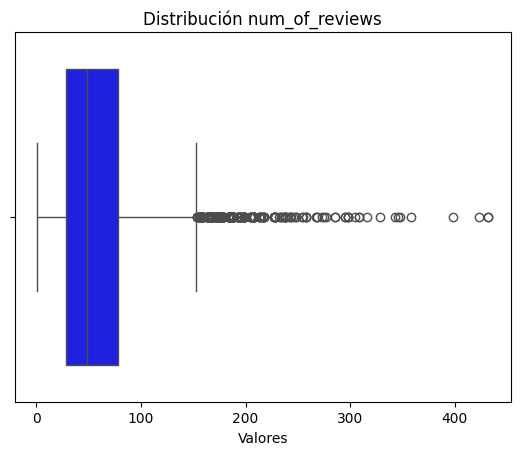

In [116]:
# Crear el gráfico de caja
sns.boxplot(x=df_subway_restaurantes['cantidad_resenas'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

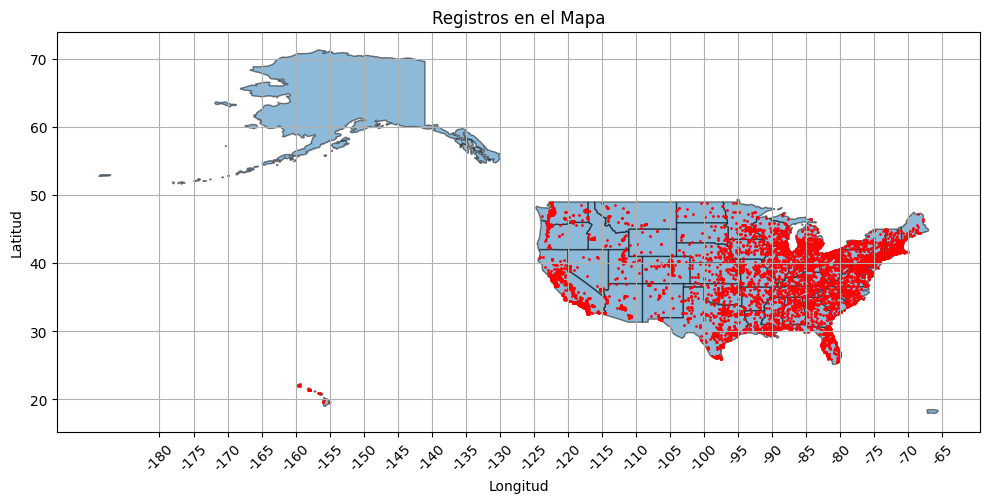

In [117]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_subway_restaurantes, geometry=gpd.points_from_xy(df_subway_restaurantes['longitud'], df_subway_restaurantes['latitud']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

listado de restaurantes fuera de estados unidos

In [118]:
df_subway_restaurantes.loc[(df_subway_restaurantes['latitud'] < 21) & (df_subway_restaurantes['longitud'] < -70) & (df_subway_restaurantes['longitud'] > -80)]

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion


### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [119]:
restaurantes = df_subway_restaurantes['id_restaurante'].to_list()
df_subway_reviews = df_subway_reviews[df_subway_reviews['id_restaurante'].isin(restaurantes)]
df_subway_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50103 entries, 2640 to 12318246
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              50103 non-null  object 
 1   id_restaurante          50103 non-null  object 
 2   id_resena               50103 non-null  object 
 3   calificacion            50103 non-null  int64  
 4   anio                    50103 non-null  int32  
 5   puntaje_de_sentimiento  50103 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 2.5+ MB


### df_subway_reviews

In [120]:
df_subway_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50103 entries, 2640 to 12318246
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              50103 non-null  object 
 1   id_restaurante          50103 non-null  object 
 2   id_resena               50103 non-null  object 
 3   calificacion            50103 non-null  int64  
 4   anio                    50103 non-null  int32  
 5   puntaje_de_sentimiento  50103 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 2.5+ MB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [121]:
df_subway_reviews['calificacion'].value_counts()

calificacion
5    24387
4    12137
3     6675
1     4598
2     2306
Name: count, dtype: int64

## Dunkin Google

### df_dunkin_restaurantes

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [128]:
df_dunkin_restaurantes['calificacion'].value_counts()

calificacion
4.000000    205
3.900391    205
4.101562    164
3.800781    162
3.699219    124
4.199219    113
3.599609    105
3.500000     94
3.400391     67
4.300781     65
3.300781     43
3.000000     33
3.199219     31
4.398438     30
2.000000     26
4.500000     23
3.099609     20
2.900391     15
2.500000     14
5.000000     13
1.500000     13
2.400391     12
2.800781      9
2.699219      9
4.699219      9
4.601562      6
4.800781      4
2.300781      4
2.599609      4
2.199219      3
1.000000      3
2.099609      2
1.799805      2
1.900391      1
1.700195      1
4.898438      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

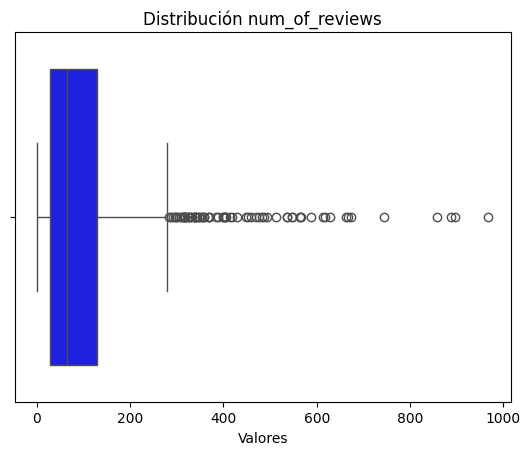

In [131]:
# Crear el gráfico de caja
sns.boxplot(x=df_dunkin_restaurantes['cantidad_resenas'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

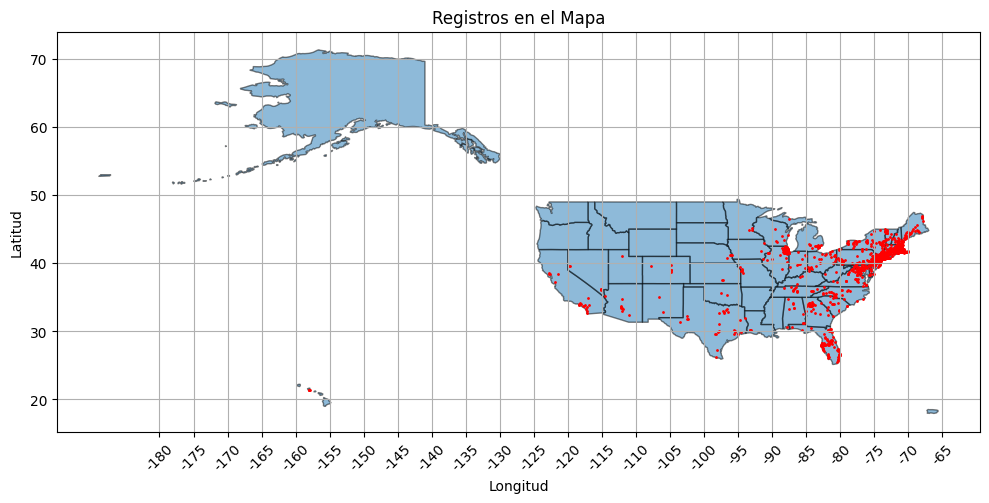

In [132]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_dunkin_restaurantes, geometry=gpd.points_from_xy(df_dunkin_restaurantes['longitud'], df_dunkin_restaurantes['latitud']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [133]:
restaurantes = df_dunkin_restaurantes['id_restaurante'].to_list()
df_dunkin_reviews = df_dunkin_reviews[df_dunkin_reviews['id_restaurante'].isin(restaurantes)]
df_dunkin_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30709 entries, 8927 to 12337579
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              30709 non-null  object 
 1   id_restaurante          30709 non-null  object 
 2   id_resena               30709 non-null  object 
 3   calificacion            30709 non-null  int64  
 4   anio                    30709 non-null  int32  
 5   puntaje_de_sentimiento  30709 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.5+ MB


### df_dunkin_reviews

In [134]:
df_dunkin_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30709 entries, 8927 to 12337579
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              30709 non-null  object 
 1   id_restaurante          30709 non-null  object 
 2   id_resena               30709 non-null  object 
 3   calificacion            30709 non-null  int64  
 4   anio                    30709 non-null  int32  
 5   puntaje_de_sentimiento  30709 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.5+ MB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [135]:
df_dunkin_reviews['calificacion'].value_counts()

calificacion
5    15517
4     7153
3     3920
1     2559
2     1560
Name: count, dtype: int64

## McDonald's Google

### df_mcdonalds_restaurantes

In [138]:
df_mcdonalds_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1219 entries, 193 to 211881
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_restaurante    1219 non-null   object 
 1   id_estado         1219 non-null   float64
 2   nombre            1219 non-null   object 
 3   categorias        1219 non-null   object 
 4   cantidad_resenas  1219 non-null   int64  
 5   latitud           1219 non-null   float64
 6   longitud          1219 non-null   float64
 7   atributos         1219 non-null   object 
 8   calificacion      1219 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 95.2+ KB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [140]:
df_mcdonalds_restaurantes['calificacion'].value_counts()

calificacion
3.500000    139
3.599609    126
3.400391    121
3.300781    109
1.500000    106
2.000000     87
3.699219     78
3.199219     63
2.500000     59
3.000000     54
3.800781     52
3.099609     49
2.900391     32
1.000000     19
3.900391     17
2.599609     16
2.400391     12
4.000000     12
2.699219     10
2.199219     10
2.800781     10
4.101562      8
2.300781      6
1.799805      4
2.099609      3
1.900391      3
1.700195      3
4.199219      3
4.699219      2
4.500000      2
1.599609      2
4.398438      1
4.300781      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

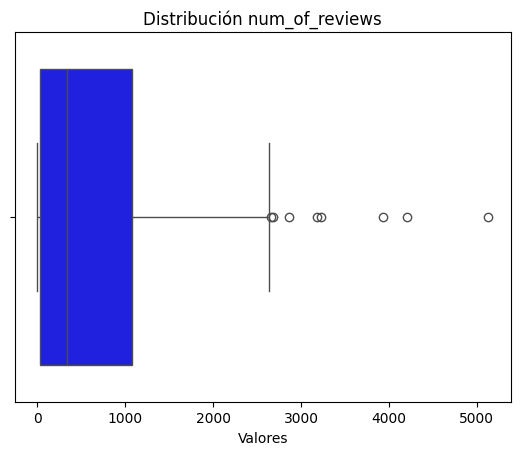

In [141]:
# Crear el gráfico de caja
sns.boxplot(x=df_mcdonalds_restaurantes['cantidad_resenas'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

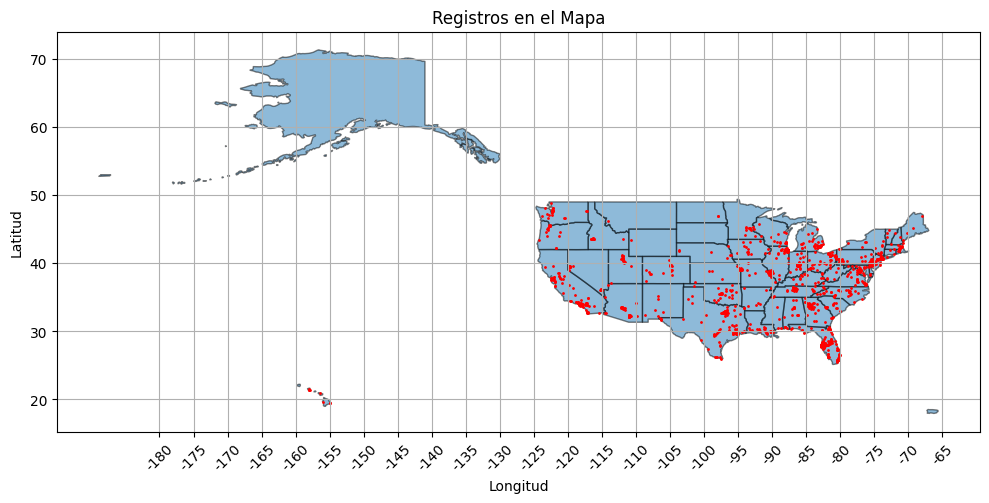

In [142]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_mcdonalds_restaurantes, geometry=gpd.points_from_xy(df_mcdonalds_restaurantes['longitud'], df_mcdonalds_restaurantes['latitud']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

El punto que parece que esta en el mar al sur de miami no es un Outlier, es un local que se encuentra en una isla llamada "Cayo Hueso"

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [144]:
restaurantes = df_mcdonalds_restaurantes['id_restaurante'].to_list()
df_mcdonalds_reviews = df_mcdonalds_reviews[df_mcdonalds_reviews['id_restaurante'].isin(restaurantes)]
df_mcdonalds_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157318 entries, 1107 to 12219980
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_usuario              157318 non-null  object 
 1   id_restaurante          157318 non-null  object 
 2   id_resena               157318 non-null  object 
 3   calificacion            157318 non-null  int64  
 4   anio                    157318 non-null  int32  
 5   puntaje_de_sentimiento  157318 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 7.8+ MB


### df_mcdonalds_reviews

In [145]:
df_mcdonalds_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157318 entries, 1107 to 12219980
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_usuario              157318 non-null  object 
 1   id_restaurante          157318 non-null  object 
 2   id_resena               157318 non-null  object 
 3   calificacion            157318 non-null  int64  
 4   anio                    157318 non-null  int32  
 5   puntaje_de_sentimiento  157318 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 7.8+ MB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [147]:
df_mcdonalds_reviews['calificacion'].value_counts()

calificacion
5    59208
4    34315
3    29768
1    21327
2    12700
Name: count, dtype: int64

## Burger king Google

### df_burger_king_restaurantes

In [151]:
df_burger_king_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 1329 to 211922
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_restaurante    768 non-null    object 
 1   id_estado         768 non-null    float64
 2   nombre            768 non-null    object 
 3   categorias        768 non-null    object 
 4   cantidad_resenas  768 non-null    int64  
 5   latitud           768 non-null    float64
 6   longitud          768 non-null    float64
 7   atributos         767 non-null    object 
 8   calificacion      768 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 60.0+ KB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [152]:
df_burger_king_restaurantes['calificacion'].value_counts()

calificacion
3.500000    65
3.599609    60
3.300781    55
3.400391    50
3.800781    49
3.699219    49
2.000000    47
1.500000    45
3.000000    44
3.199219    38
2.500000    35
3.900391    35
3.099609    33
2.800781    22
2.400391    18
4.000000    16
2.900391    15
2.699219    15
4.101562    11
1.000000    10
2.599609    10
2.099609     7
2.300781     7
1.900391     7
4.300781     4
2.199219     4
1.599609     3
4.500000     3
1.799805     2
1.299805     2
1.700195     2
4.199219     2
4.699219     1
4.601562     1
1.099609     1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

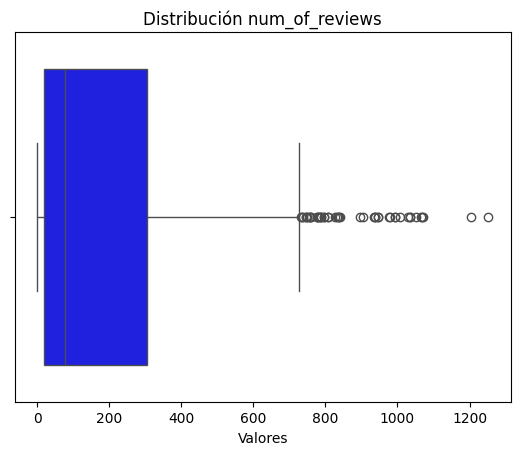

In [154]:
# Crear el gráfico de caja
sns.boxplot(x=df_burger_king_restaurantes['cantidad_resenas'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

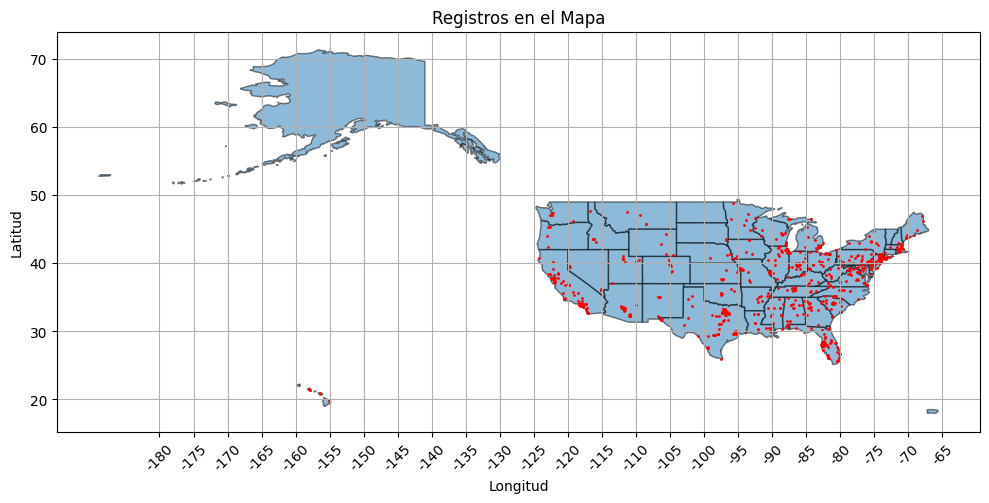

In [155]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_burger_king_restaurantes, geometry=gpd.points_from_xy(df_burger_king_restaurantes['longitud'], df_burger_king_restaurantes['latitud']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

El punto que parece que esta en el mar al sur de miami no es un Outlier, es un local que se encuentra en una isla llamada "Cayo Hueso"

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [156]:
restaurantes = df_burger_king_restaurantes['id_restaurante'].to_list()
df_burger_king_reviews = df_burger_king_reviews[df_burger_king_reviews['id_restaurante'].isin(restaurantes)]
df_burger_king_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27011 entries, 3220 to 12153898
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              27011 non-null  object 
 1   id_restaurante          27011 non-null  object 
 2   id_resena               27011 non-null  object 
 3   calificacion            27011 non-null  int64  
 4   anio                    27011 non-null  int32  
 5   puntaje_de_sentimiento  27011 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.3+ MB


### df_burger_king_reviews

In [157]:
df_burger_king_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27011 entries, 3220 to 12153898
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              27011 non-null  object 
 1   id_restaurante          27011 non-null  object 
 2   id_resena               27011 non-null  object 
 3   calificacion            27011 non-null  int64  
 4   anio                    27011 non-null  int32  
 5   puntaje_de_sentimiento  27011 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.3+ MB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [159]:
df_burger_king_reviews['calificacion'].value_counts()

calificacion
5    10633
4     6303
3     4741
1     3415
2     1919
Name: count, dtype: int64

# Distribuciòn de los datos

## df_yelp_restaurantes

### `state`

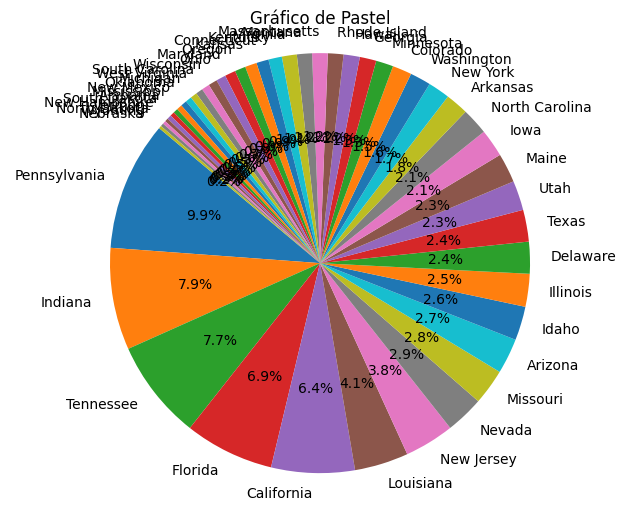

In [176]:

estado_dict = dict(zip(df_estados['id_estado'], df_estados['State']))

# Mapear los nombres de los estados en lugar de IDs
estado_labels = df_restaurantes['id_estado'].map(estado_dict)

plt.figure(figsize=(8, 6))
plt.pie(df_restaurantes['id_estado'].value_counts(), 
        labels=estado_labels.unique(), 
        autopct='%1.1f%%', 
        startangle=140)
plt.title('Gráfico de Pastel')
plt.axis('equal')  # Para asegurar que el pastel se vea como un círculo
plt.show()


### `stars`

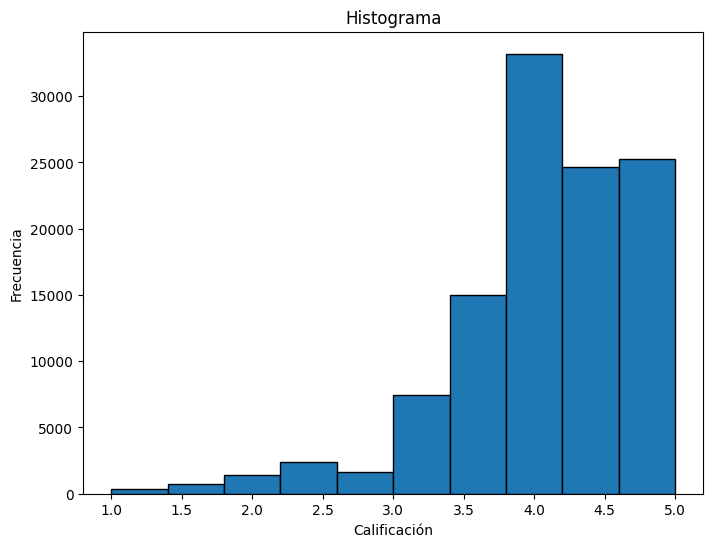

In [181]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_restaurantes['calificacion'], edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

### `review_count`

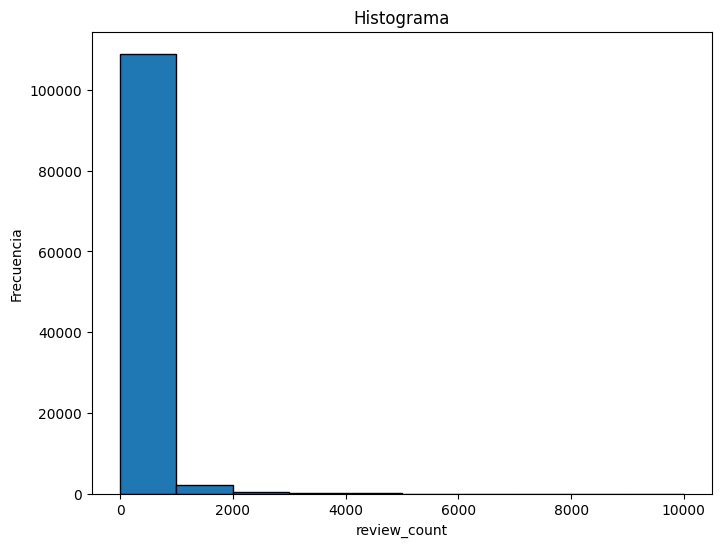

In [182]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_restaurantes['cantidad_resenas'],edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('review_count')
plt.ylabel('Frecuencia')
plt.show()

# Estados

## Describir el DataFrame

In [187]:
df = df_estados

In [188]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id_estado           50 non-null     int64 
 1   State               50 non-null     object
 2   State Abbreviation  50 non-null     object
 3   Population          50 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ KB
None


,id_estado,State,State Abbreviation,Population
0,1,Alabama,AL,5024279
1,2,Alaska,AK,733391
2,3,Arizona,AZ,7151502
3,4,Arkansas,AR,3011524
4,5,California,CA,39538223


### Comprobar la Existencia de Valores Nulos

In [189]:
print(df.isnull().sum())

id_estado             0
State                 0
State Abbreviation    0
Population            0
dtype: int64


### Estadísticas descriptivas

In [190]:
print(df.describe())

       id_estado    Population
count   50.00000  5.000000e+01
mean    25.50000  6.615296e+06
std     14.57738  7.435818e+06
min      1.00000  5.768510e+05
25%     13.25000  1.869706e+06
50%     25.50000  4.581796e+06
75%     37.75000  7.566836e+06
max     50.00000  3.953822e+07


### Estadísticas descriptivas para columnas categòricas

In [191]:
print(df.describe(include=['object']))

          State State Abbreviation
count        50                 50
unique       50                 50
top     Alabama                 AL
freq          1                  1


## Visualización de los Datos

### Histograma de la población

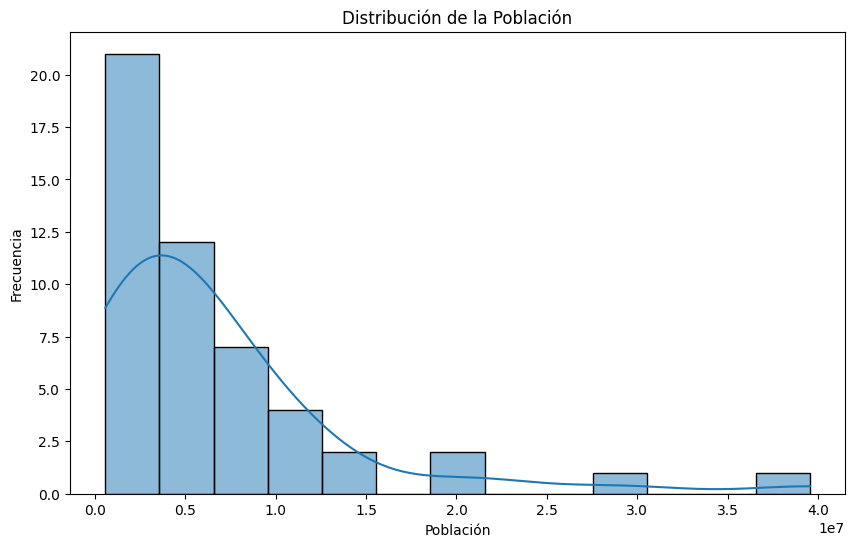

In [192]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Population'], kde=True)
plt.title('Distribución de la Población')
plt.xlabel('Población')
plt.ylabel('Frecuencia')
plt.show()

### Gráfico de barras de la población por estado

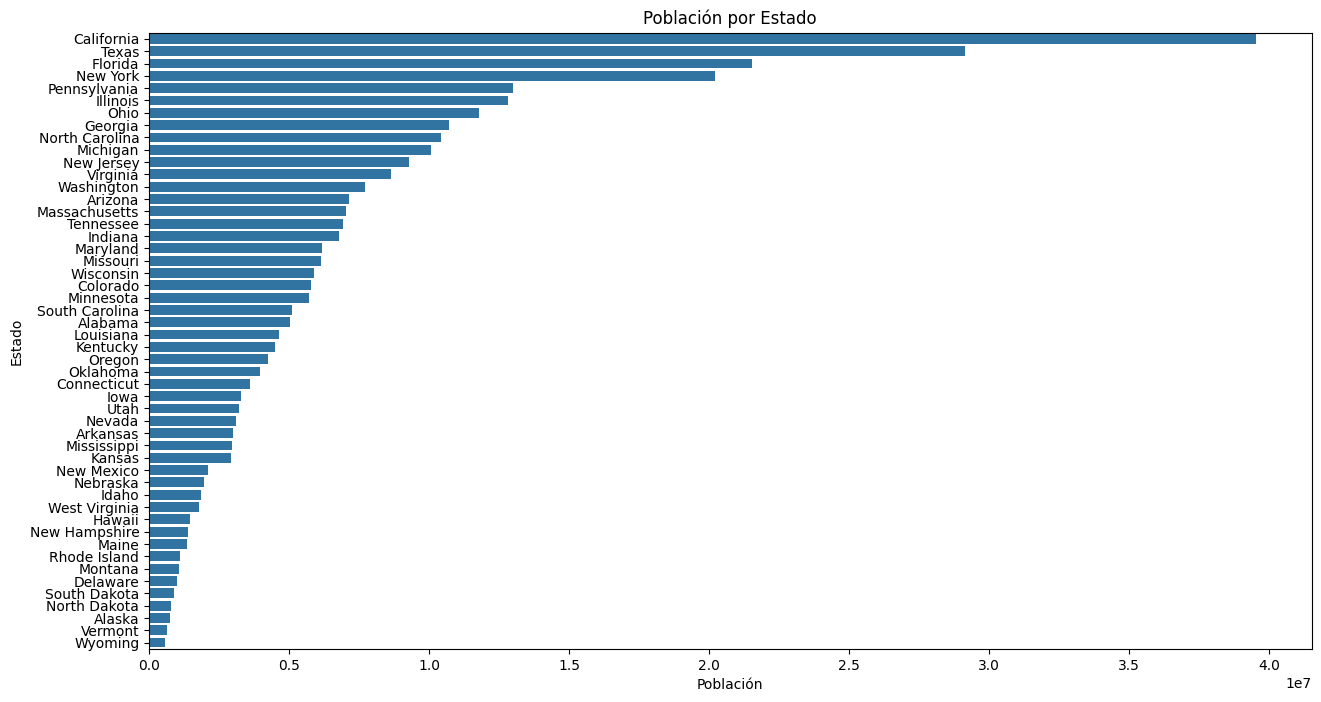

In [193]:
plt.figure(figsize=(15, 8))
sns.barplot(x='Population', y='State', data=df.sort_values('Population', ascending=False))
plt.title('Población por Estado')
plt.xlabel('Población')
plt.ylabel('Estado')
plt.show()

# Restaurantes

## Describir el DataFrame

In [195]:
df = df_restaurantes

In [196]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 111914 entries, 3 to 212012
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id_restaurante    111914 non-null  object 
 1   id_estado         111914 non-null  float64
 2   nombre            111914 non-null  object 
 3   categorias        111914 non-null  object 
 4   cantidad_resenas  111914 non-null  int64  
 5   latitud           111914 non-null  float64
 6   longitud          111914 non-null  float64
 7   atributos         111047 non-null  object 
 8   calificacion      111914 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 8.5+ MB
None


,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion
3,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.0
22,kfNv-JZpuN6TVNSO6hHdkw,14.0,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.0
29,sqSqqLy0sN8n2IZrAbzidQ,42.0,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.5
35,aPNXGTDkf-4bjhyMBQxqpQ,38.0,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.5
61,seKihQKpGGnCeLuELRQPSQ,14.0,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.5


### Comprobar la Existencia de Valores Nulos

In [197]:
print(df.isnull().sum())

id_restaurante        0
id_estado             0
nombre                0
categorias            0
cantidad_resenas      0
latitud               0
longitud              0
atributos           867
calificacion          0
dtype: int64


### Porcentaje de Valores Nulos

In [198]:
# Calcular el porcentaje de valores nulos por columna
nulos_porcentaje = df.isnull().mean() * 100
print(nulos_porcentaje)

del nulos_porcentaje

id_restaurante      0.000000
id_estado           0.000000
nombre              0.000000
categorias          0.000000
cantidad_resenas    0.000000
latitud             0.000000
longitud            0.000000
atributos           0.774702
calificacion        0.000000
dtype: float64


### Estadísticas Descriptivas

In [199]:
# Estadísticas descriptivas para columnas numéricas
print(df.describe())

           id_estado  cantidad_resenas        latitud       longitud  \
count  111914.000000     111914.000000  111914.000000  111914.000000   
mean       24.467975        132.757305      37.320447     -90.536168   
std        14.504963        330.096429       5.117410      15.798739   
min         1.000000          1.000000      19.060045    -159.671753   
25%         9.000000         18.000000      33.760900     -97.352791   
50%        25.000000         48.000000      38.672540     -86.198171   
75%        38.000000        108.000000      40.855341     -77.812601   
max        50.000000       9998.000000      48.997475     -66.984768   

        calificacion  
count  111914.000000  
mean        4.053937  
std         0.665589  
min         1.000000  
25%         3.699219  
50%         4.199219  
75%         4.500000  
max         5.000000  


### Estadísticas Descriptivas para Columnas Categóricas

#### Definiciòn de funciones para el analisis de las columnas categóricas

In [200]:

def analizar_nombre(df, columna):
    # Calcular la cantidad total de entradas
    total = len(df)
    
    # Calcular la cantidad de entradas únicas
    unicos = df[columna].nunique()
    
    # Contar la frecuencia de cada entrada
    conteo = df[columna].value_counts()
    
    # Obtener las tres entradas más comunes y su frecuencia
    top3 = conteo.head(3)
    
    return {
        "Cantidad Total de Restaurantes": total,
        "Cantidad de Restaurantes Únicos": unicos,
        "Top 3 Restaurantes Más Comunes": top3.to_dict()
    }

In [201]:

def analizar_categorias(df, columna_categorias):
    # Convertir la columna de categorías a una lista de listas
    categorias_lista = df[columna_categorias].apply(lambda x: x.split(', ')).tolist()
    
    # Crear una lista plana de todas las categorías
    todas_categorias = [categoria for sublist in categorias_lista for categoria in sublist]
    
    # Calcular la cantidad total de categorías
    cantidad_total = len(todas_categorias)
    
    # Calcular la cantidad de categorías únicas
    categorias_unicas = pd.Series(todas_categorias).nunique()
    
    # Contar la frecuencia de cada categoría
    conteo_categorias = pd.Series(todas_categorias).value_counts()
    
    # Obtener las tres categorías más repetidas y su frecuencia
    top3_categorias = conteo_categorias.head(3)
    
    return {
        "Cantidad Total de Categorías": cantidad_total,
        "Cantidad de Categorías Únicas": categorias_unicas,
        "Top 3 Categorías Más Repetidas": top3_categorias.to_dict()
    }

#### Llamado a las funciones

In [202]:
analizar_nombre(df, 'nombre')

{'Cantidad Total de Restaurantes': 111914,
 'Cantidad de Restaurantes Únicos': 69182,
 'Top 3 Restaurantes Más Comunes': {'Subway': 8537,
  "Domino's Pizza": 1794,
  "Dunkin'": 1626}}

In [203]:
analizar_categorias(df, 'categorias')

{'Cantidad Total de Categorías': 383154,
 'Cantidad de Categorías Únicas': 3235,
 'Top 3 Categorías Más Repetidas': {"['Restaurant']": 28720,
  "'Restaurant']": 27597,
  "'Fast food restaurant'": 16459}}

## Visualización de los Datos

### Histograma de la Calificación

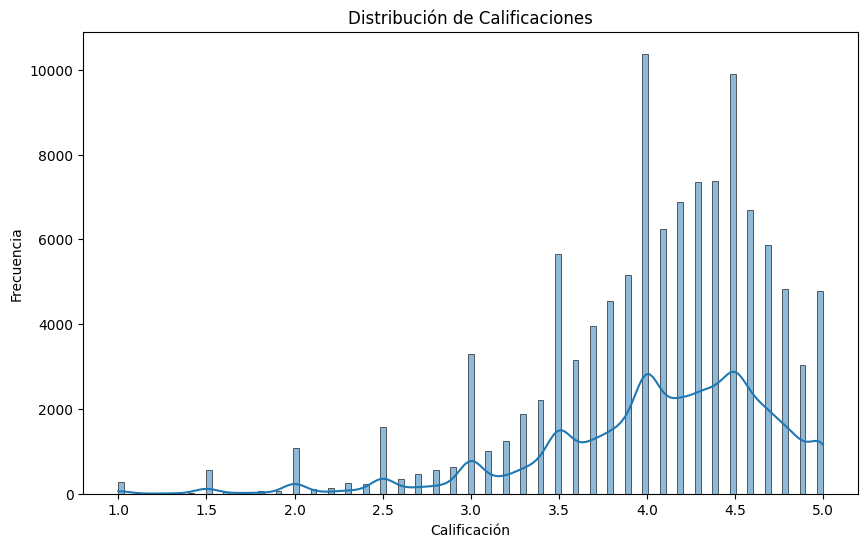

In [204]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calificacion'], kde=True)
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

### Gráfico de Barras de la Cantidad de Reseñas

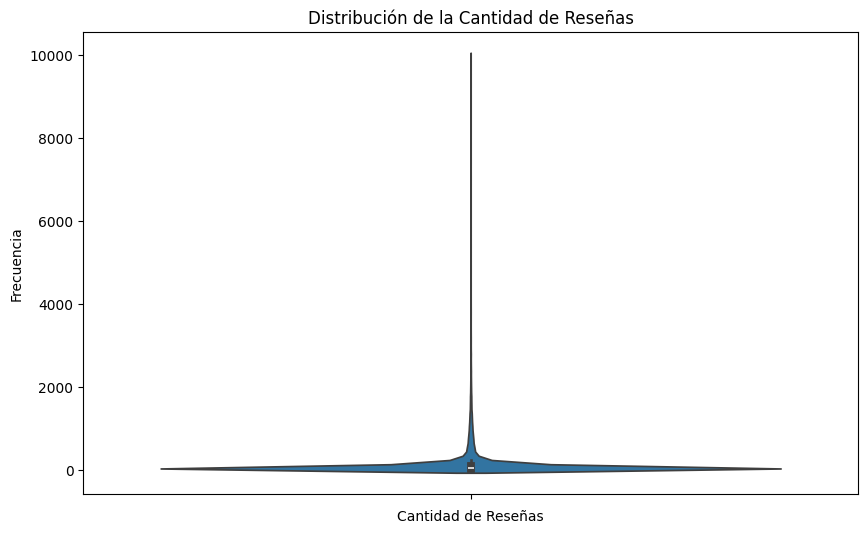

In [205]:
plt.figure(figsize=(10, 6))
sns.violinplot(df['cantidad_resenas'])
plt.title('Distribución de la Cantidad de Reseñas')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

### Mapa de Calor de Correlaciones

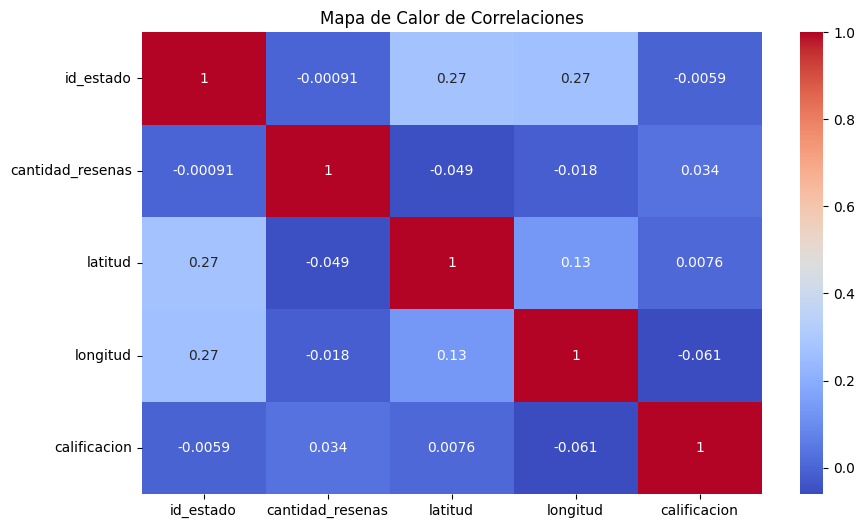

In [206]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

del numeric_df

### Distribución Geográfica de los Restaurantes

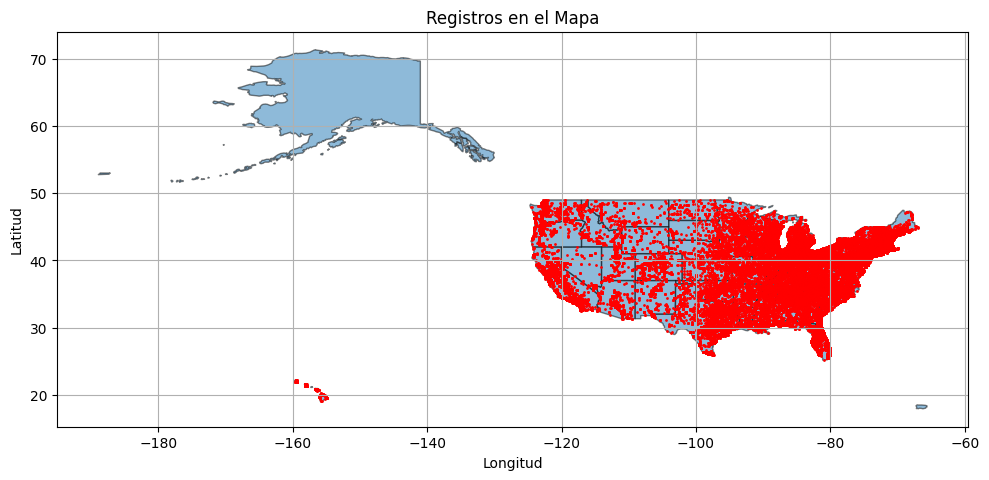

In [207]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitud'], df['latitud']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

del usa_geojson
del usa_gpd
del registros_gdf

### Gráfico de Barras de los Restaurantes Más Presentes

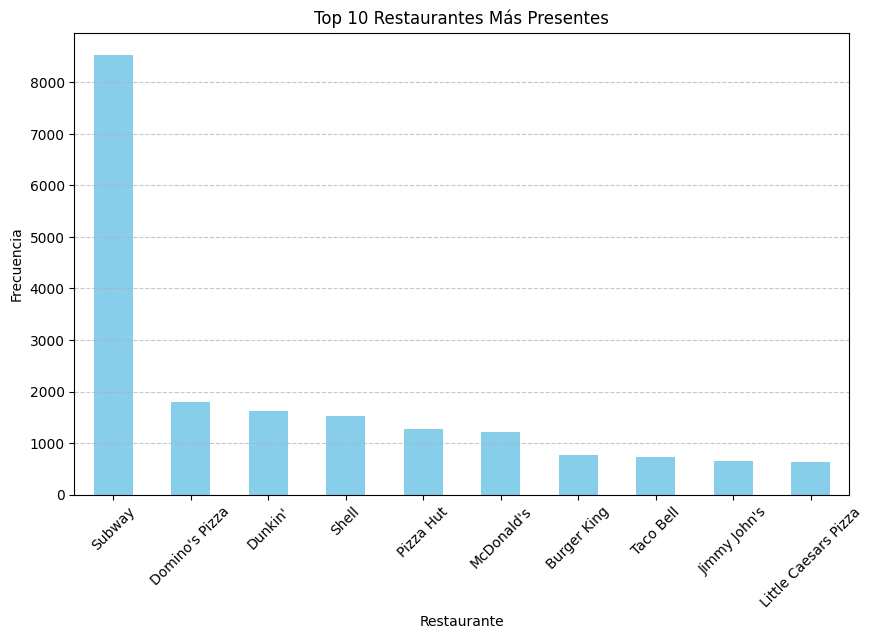

In [208]:
frecuencia_restaurantes = df['nombre'].value_counts().head(10)

plt.figure(figsize=(10, 6))
frecuencia_restaurantes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Restaurantes Más Presentes')
plt.xlabel('Restaurante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

del frecuencia_restaurantes

### Gráfico de Barras de las Frecuencia de las categorías

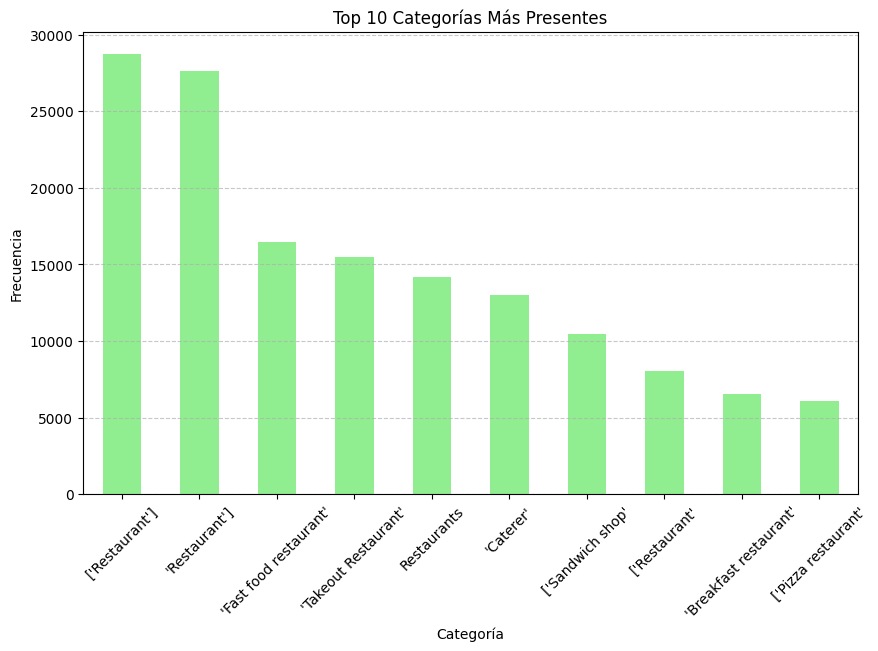

In [209]:
# Primero, desanidaremos la columna de categorías
categorias_desanidadas = df['categorias'].str.split(', ').explode()

# Contar la frecuencia de las categorías
frecuencia_categorias = categorias_desanidadas.value_counts().head(10)

plt.figure(figsize=(10, 6))
frecuencia_categorias.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Categorías Más Presentes')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

del categorias_desanidadas
del frecuencia_categorias

# Reseñas

## Describir el DataFrame

In [212]:
df = df_reviews

In [213]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2216614 entries, 14 to 12337579
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id_usuario              object 
 1   id_restaurante          object 
 2   id_resena               object 
 3   calificacion            int64  
 4   anio                    int32  
 5   puntaje_de_sentimiento  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 109.9+ MB
None


,id_usuario,id_restaurante,id_resena,calificacion,anio,puntaje_de_sentimiento
14,GtqEcbHF-WTfKlms9250ZQ,7wQEzj-0yOpLiANNLuUflQ,nAE4IGJMRxDfas0qYabMWw,4,2016,7.8
16,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,4KpIldEM-tdnrJLqYzRfZQ,5,2018,7.3
17,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,PDHRlnEdkEcwATry4w71PQ,1,2011,4.6
22,EfG0nInFMbiO9Hy7A6B2cQ,fGYnHzFr1z2kv7bPRW6VMA,jSoo6p_GpvYRHG2QK6WE2g,3,2017,7.1
25,JriXL8qqw_tJ1mpwtlBabg,1QVB0_-piu0GXes87BXeGw,OJO7m2zn3LAr011J1I7ppQ,5,2017,7.1


### Comprobar la Existencia de Valores Nulos

In [214]:
print(df.isnull().sum())

id_usuario                0
id_restaurante            0
id_resena                 0
calificacion              0
anio                      0
puntaje_de_sentimiento    0
dtype: int64


### Estadísticas descriptivas

In [215]:
print(df.describe())

       calificacion          anio  puntaje_de_sentimiento
count  2.216614e+06  2.216614e+06            2.216614e+06
mean   4.126175e+00  2.018468e+03            6.119645e+00
std    1.209097e+00  1.923271e+00            1.618538e+00
min    1.000000e+00  1.990000e+03            0.000000e+00
25%    4.000000e+00  2.018000e+03            5.000000e+00
50%    5.000000e+00  2.019000e+03            5.400000e+00
75%    5.000000e+00  2.020000e+03            7.200000e+00
max    5.000000e+00  2.022000e+03            1.000000e+01


### Estadísticas descriptivas para columnas categòricas

In [216]:
print(df.describe(include=['object']))

                    id_usuario                         id_restaurante  \
count                  2216614                                2216614   
unique                 1507203                                  30628   
top     vmUqcqMjlWoBM6qfmUXgyQ  0x40771e59f0513085:0x513683476a2005d8   
freq                        87                                   7148   

                     id_resena  
count                  2216614  
unique                 2216614  
top     nAE4IGJMRxDfas0qYabMWw  
freq                         1  


## Visualización de los Datos

### Histograma de la Calificación

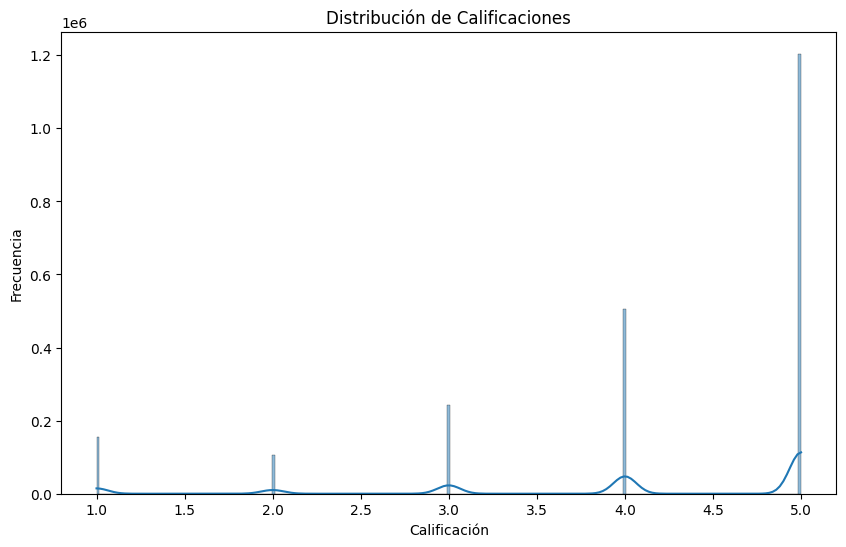

In [217]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calificacion'], kde=True)
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

### Histograma del Puntaje del Analisis de Sentimientos

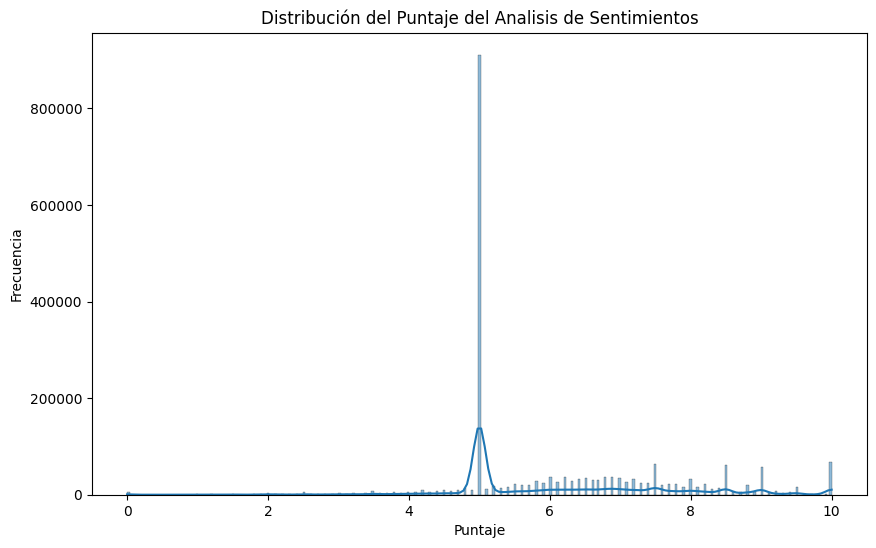

In [220]:
plt.figure(figsize=(10, 6))
sns.histplot(df['puntaje_de_sentimiento'], kde=True)
plt.title('Distribución del Puntaje del Analisis de Sentimientos')
plt.xlabel('Puntaje')
plt.ylabel('Frecuencia')
plt.show()

### Mapa de Calor de Correlaciones

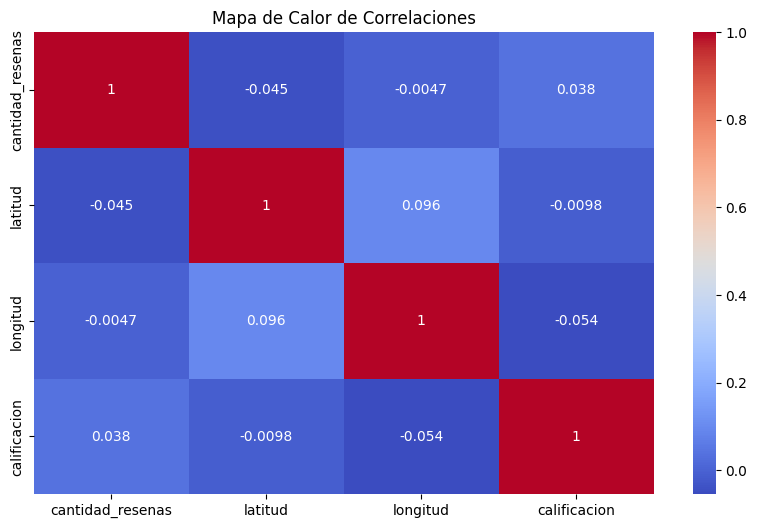

In [ ]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

del numeric_df

### Gráfico de Barras de La Frecuencia de Reseñas a los largo de los Años

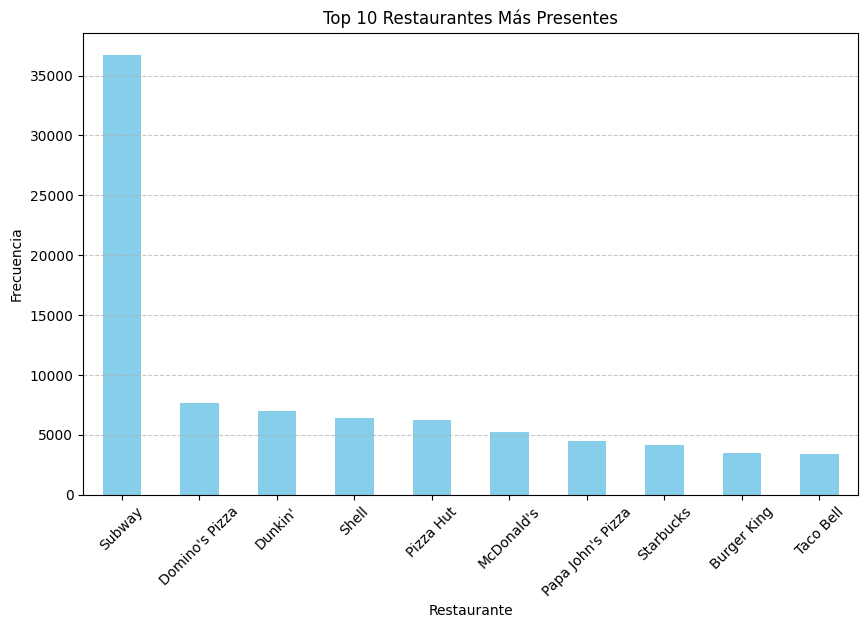

In [ ]:
frecuencia_anios = df['anio'].value_counts()

plt.figure(figsize=(10, 6))
frecuencia_anios.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Reseñas a los largo de los Años')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

del frecuencia_anios